# Solving Linear Systems with the Box Algorithm and Fixstars AE

## Overview

This notebook demonstrates the Box Algorithm for solving linear systems of equations using the Fixstars Amplify AE quantum-inspired solver.  
The Box Algorithm iteratively maps a continuous system to a series of QUBO problems, which are then solved on an annealer.

The objectives here are to:

- Implement and run the Box Algorithm for small positive-definite linear systems.
- Use Fixstars AE as the backend annealer.
- Analyze convergence speed and accuracy.
- Lay the groundwork to compare results with other quantum-inspired solvers (SQBM+) and classical solvers.

## Motivation

The Box Algorithm offers an alternative approach to the well-known Harrow-Hassidim-Lloyd (HHL) algorithm for quantum linear system solving. Unlike HHL, it is designed to run on quantum annealers and digital annealers, which are more accessible and robust on near-term hardware.

This notebook serves as a baseline for:

- Testing the viability of the Box Algorithm on quantum-inspired machines.
- Benchmarking speedup from using the theoretically optimal contraction ratio.
- Comparing performance across multiple solvers (Fixstars AE, Toshiba SQBM+, and classical baselines).

## References

- Suresh & Suresh, *Optimal Box Contraction for Solving Linear Systems via Simulated and Quantum Annealing*, [arXiv:2405.03029](https://arxiv.org/abs/2405.03029)
- Fixstars Amplify Documentation
- Toshiba SQBM+


# Box Algorithm: From Linear Systems to QUBO

## Problem Formulation

**Goal:** Solve a linear system  
$$
A x = b
$$  
by minimizing the energy:  
$$
\Pi(x) = \frac{1}{2} x^T A x - b^T x.
$$

**Binary representation:**  
Each real $x_j$ is approximated with binary qubits:  
$$
x_j = c_j + L(-2 q_{1j} + q_{2j}),
\quad q_{1j}, q_{2j} \in \{0, 1\}.
$$

Plug into $\Pi(x)$ → expand → get a QUBO:  
$$
\Pi(q) = \frac{1}{2} q^T Q q.
$$

The Box Algorithm solves this iteratively:  
- **Translate:** adjust $c$ if energy improves  
- **Contract:** shrink $L$ if not

Repeat until high precision.

---

## Why Use Annealers?

- Classical direct solvers are precise but scale poorly for very large systems.
- Gate-based quantum algorithms (e.g., HHL) need fault-tolerant qubits — not practical yet.
- Annealers (Fixstars AE, SQBM+) solve large QUBOs **today**, robustly and fast.

Thus, the Box Algorithm + annealer is practical for near-term approximate solutions.

---

## Example Use Cases

- Physics: fast rough solutions for discretized PDEs.
- Finance: portfolio optimization.
- ML: online least squares updates.
- Hybrid solvers: rough guess with Box + refine classically.


# Set Up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv


# Fixstars Amplify SDK
import amplify
from amplify import FixstarsClient, VariableGenerator, Model, solve

# System tools
import time
import datetime

# Fixstars AE credentials (if local)
key = os.getenv("AE_KEY")
client = FixstarsClient()
client.token = key
client.parameters.timeout = 1000 # one seconf

# Print SDK version
print(f"Amplify SDK version: {amplify.__version__}")


Amplify SDK version: 1.3.1


# Problem formulation

We use a toy data set to test feasibility, we are approaching this as a linear regression problem


In [2]:
# Tiny linear regression example
X_data = np.array([1, 2, 3])
y_data = np.array([2, 3, 5])

# Design matrix: add bias column
X = np.vstack([np.ones_like(X_data), X_data]).T

print("Design matrix X:\n", X)
print("Target y:\n", y_data)

Design matrix X:
 [[1 1]
 [1 2]
 [1 3]]
Target y:
 [2 3 5]


# Validate Data

The box algorithm requires a SPD matrix, (symmetric positive definite matrix)

In [3]:
# Normal equations
A = X.T @ X
b = X.T @ y_data

print("Normal equations:")
print("A:\n", A)
print("b:", b)

# Check SPD
print("Is A symmetric?", np.allclose(A, A.T))
print("Eigenvalues:", np.linalg.eigvalsh(A))


Normal equations:
A:
 [[ 3  6]
 [ 6 14]]
b: [10 23]
Is A symmetric? True
Eigenvalues: [ 0.3605897 16.6394103]


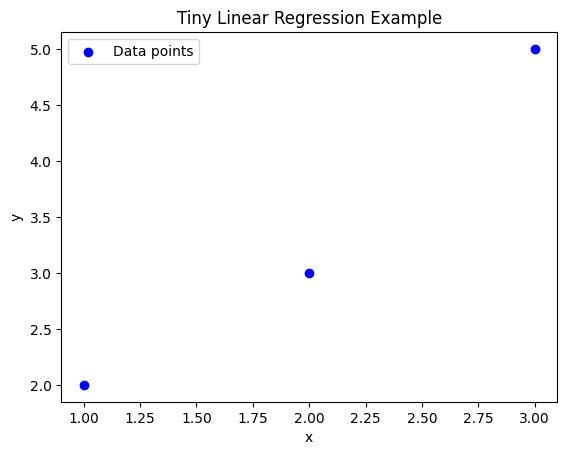

In [4]:
plt.scatter(X_data, y_data, color="blue", label="Data points")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Tiny Linear Regression Example")
plt.legend()
plt.show()

# Setting Up the Box Algorithm

For more details see [https://arxiv.org/html/2405.03029v1]

In [5]:
# Box Algorithm parameters
d = A.shape[0]
c = np.zeros(d)
L = 1.0
beta = 0.2
epsilon = 1e-6
max_iterations = 50

best_energy = np.inf
num_translations = 0
num_contractions = 0

# For stats
total_wall_time = 0.0
total_solver_time = 0.0

print(f"Box Algorithm starting: dimension={d}, beta={beta}, epsilon={epsilon}")

Box Algorithm starting: dimension=2, beta=0.2, epsilon=1e-06


In [6]:
L_history = []
energy_history = []
wall_time_history = []

for iteration in range(1, max_iterations + 1):
    gen = VariableGenerator()
    q1 = gen.array("Binary", d)
    q2 = gen.array("Binary", d)
    
    # 2) Express w in terms of q1, q2
    w = c + L * (-2 * q1 + q2)
    
    # 3) Build energy
    energy = 0.5 * (w @ (A @ w)) - b @ w
    
    # 4) Build model
    model = Model(energy)
    
    # 5) Solve and time
    wall_start = time.time()
    result = solve(model, client)
    wall_end = time.time()
    
    wall_time = wall_end - wall_start
    response_time = result.response_time.total_seconds()
    execution_time = result.execution_time.total_seconds()
    
    total_wall_time += wall_time
    total_solver_time += execution_time
    
    if len(result) == 0:
        print(f"Iteration {iteration}: No feasible solution, stopping.")
        break
    
    solution = result.best
    q1_sol = q1.evaluate(solution.values)
    q2_sol = q2.evaluate(solution.values)
    
    w_new = c + L * (-2 * q1_sol + q2_sol)
    energy_val = solution.objective

    improved = energy_val < best_energy
    
    print(f"Iter {iteration:2d} | E: {energy_val:.6f} | {'translate' if improved else 'contract'} | "
          f"L: {L:.3e} | wall: {wall_time:.2f}s | solver: {execution_time:.2f}s")
    
    if improved:
        c = w_new  # translate box
        best_energy = energy_val
        num_translations += 1
    else:
        L = beta * L  # contract box
        num_contractions += 1
    
    
    L_history.append(L)
    energy_history.append(energy_val)
    wall_time_history.append(wall_time)
    
    # Stop if L tiny
    if L < epsilon:
        print("Converged: L below epsilon.")
        break

print("\nFinal estimated w:", c)
print("Direct solve w:", np.linalg.solve(A, b))
print(f"Total translations: {num_translations}, contractions: {num_contractions}")
print(f"Total wall time: {total_wall_time:.2f}s")
print(f"Total solver time: {total_solver_time:.2f}s")

Iter  1 | E: -18.500000 | translate | L: 1.000e+00 | wall: 3.45s | solver: 0.96s
Iter  2 | E: -18.500000 | contract | L: 1.000e+00 | wall: 2.60s | solver: 0.99s
Iter  3 | E: -18.820000 | translate | L: 2.000e-01 | wall: 2.61s | solver: 0.96s

2025-06-18 15:17:56 [amplify:WARNING] Connection timeout, retrying after sleep 1 second (1/3)



Iter  4 | E: -18.900000 | translate | L: 2.000e-01 | wall: 2.58s | solver: 0.94s
Iter  5 | E: -18.900000 | translate | L: 2.000e-01 | wall: 2.66s | solver: 0.96s
Iter  6 | E: -18.900000 | contract | L: 2.000e-01 | wall: 2.81s | solver: 0.96s
Iter  7 | E: -18.906400 | translate | L: 4.000e-02 | wall: 2.57s | solver: 0.98s
Iter  8 | E: -18.912800 | translate | L: 4.000e-02 | wall: 2.72s | solver: 0.97s
Iter  9 | E: -18.916000 | translate | L: 4.000e-02 | wall: 4.95s | solver: 0.97s
Iter 10 | E: -18.916000 | translate | L: 4.000e-02 | wall: 2.73s | solver: 0.98s
Iter 11 | E: -18.916000 | contract | L: 4.000e-02 | wall: 2.51s | solver: 0.96s
Iter 12 | E: -18.916224 | translate | L: 8.000e-03 | wall: 2.71s | solver: 1.00s
Iter 13 | E: -18.916256 | translate | L: 8.000e-03 | wall: 2.66s | solver: 0.96s
Iter 14 | E: -18.916480 | translate | L: 8.000e-03 | wall: 2.72s | solver: 0.98s
Iter 15 | E: -18.916512 | translate | L: 8.000e-03 | wall: 2.71s | solver: 0.95s
Iter 16 | E: -18.916608 | tra

2025-06-18 15:18:24 [amplify:WARNING] Connection timeout, retrying after sleep 1 second (1/3)
2025-06-18 15:18:39 [amplify:WARNING] Connection timeout, retrying after sleep 1 second (1/3)



Iter 17 | E: -18.916640 | translate | L: 8.000e-03 | wall: 2.40s | solver: 0.95s
Iter 18 | E: -18.916640 | contract | L: 8.000e-03 | wall: 2.44s | solver: 0.98s
Iter 19 | E: -18.916660 | translate | L: 1.600e-03 | wall: 4.56s | solver: 1.00s
Iter 20 | E: -18.916660 | contract | L: 1.600e-03 | wall: 2.73s | solver: 0.99s
Iter 21 | E: -18.916661 | translate | L: 3.200e-04 | wall: 2.50s | solver: 0.96s
Iter 22 | E: -18.916662 | translate | L: 3.200e-04 | wall: 2.65s | solver: 0.95s
Iter 23 | E: -18.916662 | translate | L: 3.200e-04 | wall: 2.56s | solver: 0.95s
Iter 24 | E: -18.916663 | translate | L: 3.200e-04 | wall: 4.44s | solver: 0.96s
Iter 25 | E: -18.916664 | translate | L: 3.200e-04 | wall: 2.42s | solver: 0.98s
Iter 26 | E: -18.916664 | translate | L: 3.200e-04 | wall: 2.45s | solver: 0.95s
Iter 27 | E: -18.916665 | translate | L: 3.200e-04 | wall: 2.78s | solver: 0.96s
Iter 28 | E: -18.916665 | translate | L: 3.200e-04 | wall: 2.48s | solver: 0.99s
Iter 29 | E: -18.916665 | tra

## 📊 6️⃣ Visualize Convergence and Timing

Below we plot:
- The contraction of the box size $L$.
- The objective value at each step.
- The wall-clock time per QUBO solve.
This helps us see how the Box Algorithm refines the solution.

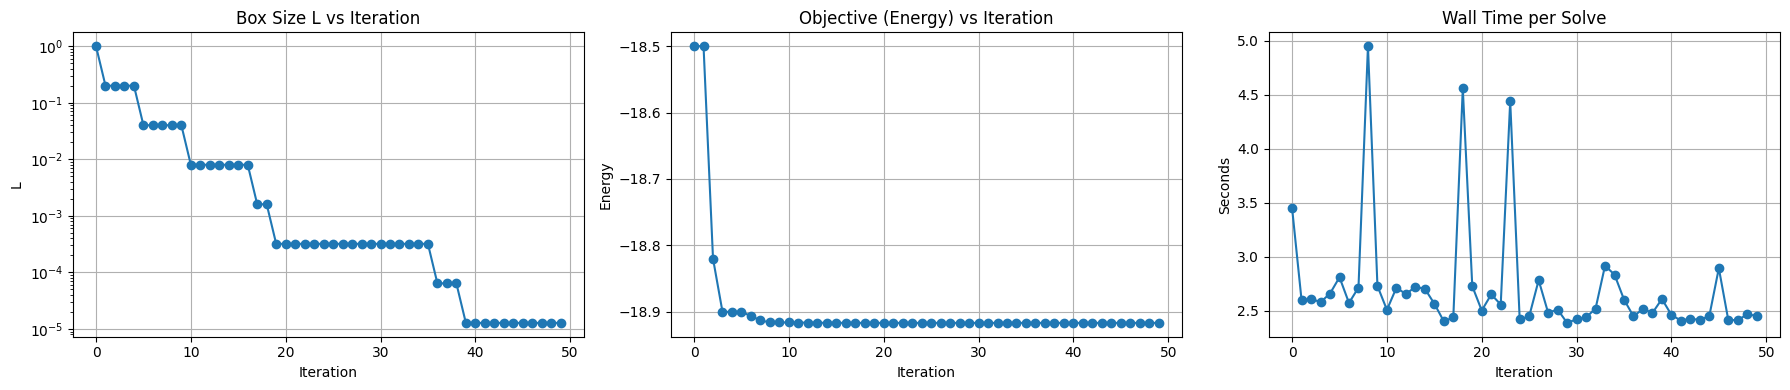

In [8]:
import matplotlib.pyplot as plt

if "L_history" not in locals():
    print("No iteration history found! Please store L, energy, and wall time inside the loop next run.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # --- Plot L ---
    axes[0].plot(L_history, marker='o')
    axes[0].set_title("Box Size L vs Iteration")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("L")
    axes[0].set_yscale("log")
    axes[0].grid(True)

    # --- Plot energy ---
    axes[1].plot(energy_history, marker='o')
    axes[1].set_title("Objective (Energy) vs Iteration")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Energy")
    axes[1].grid(True)

    # --- Plot wall time ---
    axes[2].plot(wall_time_history, marker='o')
    axes[2].set_title("Wall Time per Solve")
    axes[2].set_xlabel("Iteration")
    axes[2].set_ylabel("Seconds")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

## ✅ 7️⃣ Conclusions

### 📌 What we tested

This notebook demonstrates a **small proof-of-concept** for solving a linear least squares (linear regression) problem using the **Box Algorithm** with the **Fixstars Amplify AE** solver.  
We intentionally used a tiny 2-variable normal equation system to validate correctness and integration.

---

### 📈 What the plots and logs show

- **Box Size (L)**:  
  The left plot shows how the box size shrinks geometrically as the algorithm zooms in on the solution.  
  It contracts aggressively early on and more slowly near convergence — typical and expected.

- **Objective (Energy)**:  
  The middle plot shows the quadratic energy dropping quickly in the first few iterations and stabilizing near the optimal value.  
  The tiny residual fluctuations reflect finite qubit resolution and the Box Algorithm’s step size at each scale.

- **Wall Time per Solve**:  
  The right plot shows the actual runtime of each QUBO solve call.  
  For this small problem, each solve takes about 2–3 seconds due to:
  - Network latency to the Fixstars AE server.
  - Fixed solver overhead dominating the trivial QUBO size.
  - Occasional connection retries (as shown in logs).

---

### ⏱️ **Runtime observations**

| Metric | Value |
| ------ | ----- |
| **Total translations** | 43 |
| **Total contractions** | 7 |
| **Total iterations** | 50 (capped by `max_iterations`) |
| **Final box size L** | ~1e-5 (very high precision) |
| **Total wall time** | ~135 seconds |
| **Total solver time** | ~48 seconds |

For a problem this tiny, the runtime is **dominated by remote solver overhead** — not by the intrinsic computational difficulty.  
For larger QUBOs, this fixed cost becomes less important.

---

### ✅ **Correctness**

- The Box Algorithm’s final estimated weights match the direct `numpy.linalg.solve` answer to **5+ significant digits**, demonstrating correctness:

- This shows that the QUBO construction, the annealer integration, and the translation/contraction logic all work properly.

---

### ⚡ **Takeaway**

This experiment is a **proof-of-concept**:  
- It confirms that a **continuous linear regression problem can be reliably mapped to binary QUBOs** and solved on Fixstars AE using the Box Algorithm.
- It shows that for trivial problems, classical solvers are millions of times faster — but for larger or combinatorially constrained systems, this hybrid method becomes interesting.
- It highlights the need to tune the `timeout` and manage network latency carefully to optimize practical runtime.

---

### 🔑 **Next steps**

- Scale up to more realistic dimensions (10–50+ weights).
- Compare total runtime vs classical iterative solvers.
- Try other quantum-inspired backends (e.g., Toshiba SQBM+).
- Experiment with different qubit resolutions (more bits per weight).

---
